<a href="https://colab.research.google.com/github/mahi97/MahiColabs/blob/master/ModernConv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.datasets.mnist as mnist

In [0]:
def lrelu(x, leak=0.2, name="lrelu"):
    """Leaky rectifier.
    Parameters
    ----------
    x : Tensor
        The tensor to apply the nonlinearity to.
    leak : float, optional
        Leakage parameter.
    name : str, optional
        Variable scope to use.
    Returns
    -------
    x : Tensor
        Output of the nonlinearity.
    """
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

In [0]:
def batch_norm(x, phase_train, scope='bn', affine=True):
    """
    Batch normalization on convolutional maps.
    from: https://stackoverflow.com/questions/33949786/how-could-i-
    use-batch-normalization-in-tensorflow
    Only modified to infer shape from input tensor x.
    Parameters
    ----------
    x
        Tensor, 4D BHWD input maps
    phase_train
        boolean tf.Variable, true indicates training phase
    scope
        string, variable scope
    affine
        whether to affine-transform outputs
    Return
    ------
    normed
        batch-normalized maps
    """
    with tf.variable_scope(scope):
        shape = x.get_shape().as_list()

        beta = tf.Variable(tf.constant(0.0, shape=[shape[-1]]),
                           name='beta', trainable=True, dtype=tf.float64)
        gamma = tf.Variable(tf.constant(1.0, shape=[shape[-1]]),
                            name='gamma', trainable=affine, dtype=tf.float64)

        batch_mean, batch_var = tf.nn.moments(x, [0, 1, 2], name='moments')
        ema = tf.train.ExponentialMovingAverage(decay=0.9)
        ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)

        def mean_var_with_update():
            """Summary
            Returns
            -------
            name : TYPE
                Description
            """
            ema_apply_op = ema.apply([batch_mean, batch_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)
        mean, var = tf.cond(phase_train,
                                          mean_var_with_update,
                                          lambda: (ema_mean, ema_var))

        normed = tf.nn.batch_norm_with_global_normalization(
            x, mean, var, beta, gamma, 1e-3, affine)
    return normed

In [0]:
"""APL 2.0 code from github.com/pkmital/tensorflow_tutorials w/ permission
from Parag K. Mital.
"""
import math

def batch_norm(x, phase_train, scope='bn', affine=True):
    """
    Batch normalization on convolutional maps.
    from: https://stackoverflow.com/questions/33949786/how-could-i-
    use-batch-normalization-in-tensorflow
    Only modified to infer shape from input tensor x.
    Parameters
    ----------
    x
        Tensor, 4D BHWD input maps
    phase_train
        boolean tf.Variable, true indicates training phase
    scope
        string, variable scope
    affine
        whether to affine-transform outputs
    Return
    ------
    normed
        batch-normalized maps
    """
    with tf.variable_scope(scope):
        og_shape = x.get_shape().as_list()
        if len(og_shape) == 2:
            x = tf.reshape(x, [-1, 1, 1, og_shape[1]])
        shape = x.get_shape().as_list()
        beta = tf.Variable(tf.constant(0.0, shape=[shape[-1]], dtype=tf.float64),
                           name='beta', trainable=True)
        gamma = tf.Variable(tf.constant(1.0, shape=[shape[-1]], dtype=tf.float64),
                            name='gamma', trainable=affine)

        batch_mean, batch_var = tf.nn.moments(x, [0, 1, 2], name='moments')
        ema = tf.train.ExponentialMovingAverage(decay=0.9)
        ema_apply_op = ema.apply([batch_mean, batch_var])
        ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)

        def mean_var_with_update():
            """Summary
            Returns
            -------
            name : TYPE
                Description
            """
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)
        mean, var = tf.cond(phase_train,
                                          mean_var_with_update,
                                          lambda: (ema_mean, ema_var))

        normed = tf.nn.batch_norm_with_global_normalization(
            x, mean, var, beta, gamma, 1e-3, affine)
        if len(og_shape) == 2:
            normed = tf.reshape(normed, [-1, og_shape[-1]])
    return normed


def lrelu(x, leak=0.2, name="lrelu"):
    """Leaky rectifier.
    Parameters
    ----------
    x : Tensor
        The tensor to apply the nonlinearity to.
    leak : float, optional
        Leakage parameter.
    name : str, optional
        Variable scope to use.
    Returns
    -------
    x : Tensor
        Output of the nonlinearity.
    """
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)


def linear(x, n_units, scope=None, stddev=0.02,
           activation=lambda x: x):
    """Fully-connected network.
    Parameters
    ----------
    x : Tensor
        Input tensor to the network.
    n_units : int
        Number of units to connect to.
    scope : str, optional
        Variable scope to use.
    stddev : float, optional
        Initialization's standard deviation.
    activation : arguments, optional
        Function which applies a nonlinearity
    Returns
    -------
    x : Tensor
        Fully-connected output.
    """
    shape = x.get_shape().as_list()

    with tf.variable_scope(scope or "Linear"):
        matrix = tf.get_variable("Matrix", [shape[1], n_units], tf.float64,
                                 tf.random_normal_initializer(stddev=stddev))
        return activation(tf.matmul(x, matrix))

mahi = None
def conv2d(x, n_filters,
           k_h=5, k_w=5,
           stride_h=2, stride_w=2,
           stddev=0.02,
           activation=None,
           bias=True,
           padding='SAME',
           name="Conv2D"):
    global mahi
    """2D Convolution with options for kernel size, stride, and init deviation.
    Parameters
    ----------
    x : Tensor
        Input tensor to convolve.
    n_filters : int
        Number of filters to apply.
    k_h : int, optional
        Kernel height.
    k_w : int, optional
        Kernel width.
    stride_h : int, optional
        Stride in rows.
    stride_w : int, optional
        Stride in cols.
    stddev : float, optional
        Initialization's standard deviation.
    activation : arguments, optional
        Function which applies a nonlinearity
    padding : str, optional
        'SAME' or 'VALID'
    name : str, optional
        Variable scope to use.
    Returns
    -------
    x : Tensor
        Convolved input.
    """
    with tf.variable_scope(name):
        w = tf.get_variable(
            'w', [k_h, k_w, x.get_shape()[-1], n_filters],dtype=tf.float64,
            initializer=tf.truncated_normal_initializer(stddev=stddev))
        mahi = w
        conv = tf.nn.conv2d(
            x, w, strides=[1, stride_h, stride_w, 1], padding=padding)
        if bias:
            b = tf.get_variable(
                'b', [n_filters],
                initializer=tf.truncated_normal_initializer(stddev=stddev),dtype=tf.float64)
            conv = tf.nn.bias_add(conv, b)
        if activation:
            conv = activation(conv)
        return conv

In [0]:
def montage_batch(images):
    """Draws all filters (n_input * n_output filters) as a
    montage image separated by 1 pixel borders.
    Parameters
    ----------
    batch : numpy.ndarray
        Input array to create montage of.
    Returns
    -------
    m : numpy.ndarray
        Montage image.
    """
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    m = np.ones(
        (images.shape[1] * n_plots + n_plots + 1,
         images.shape[2] * n_plots + n_plots + 1, 3)) * 0.5

    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter, ...]
                m[1 + i + i * img_h:1 + i + (i + 1) * img_h,
                  1 + j + j * img_w:1 + j + (j + 1) * img_w, :] = this_img
    return m


# %%
def montage(W):
    """Draws all filters (n_input * n_output filters) as a
    montage image separated by 1 pixel borders.
    Parameters
    ----------
    W : numpy.ndarray
        Input array to create montage of.
    Returns
    -------
    m : numpy.ndarray
        Montage image.
    """
    W = np.reshape(W, [W.shape[0], W.shape[1], 1, W.shape[2] * W.shape[3]])
    n_plots = int(np.ceil(np.sqrt(W.shape[-1])))
    m = np.ones(
        (W.shape[0] * n_plots + n_plots + 1,
         W.shape[1] * n_plots + n_plots + 1)) * 0.5
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < W.shape[-1]:
                m[1 + i + i * W.shape[0]:1 + i + (i + 1) * W.shape[0],
                  1 + j + j * W.shape[1]:1 + j + (j + 1) * W.shape[1]] = (
                    np.squeeze(W[:, :, :, this_filter]))
    return m




# %%
def corrupt(x):
    """Take an input tensor and add uniform masking.
    Parameters
    ----------
    x : Tensor/Placeholder
        Input to corrupt.
    Returns
    -------
    x_corrupted : Tensor
        50 pct of values corrupted.
    """
    return tf.multiply(x, tf.cast(tf.random_uniform(shape=tf.shape(x),
                                               minval=0,
                                               maxval=2,
                                               dtype=tf.int32), tf.float64))


# %%
def weight_variable(shape):
    '''Helper function to create a weight variable initialized with
    a normal distribution
    Parameters
    ----------
    shape : list
        Size of weight variable
    '''
    initial = tf.random_normal(shape, mean=0.0, stddev=0.01, dtype=tf.float64)
    return tf.Variable(initial)


# %%
def bias_variable(shape):
    '''Helper function to create a bias variable initialized with
    a constant value.
    Parameters
    ----------
    shape : list
        Size of weight variable
    '''
    initial = tf.random_normal(shape, mean=0.0, stddev=0.01, dtype=tf.float64)
    return tf.Variable(initial)

In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train / 255.0
X_test = X_test / 255.0
y_test = [[0 == b,
                   1 == b,
                   2 == b,
                   3 == b,
                   4 == b,
                   5 == b,
                   6 == b,
                   7 == b,
                   8 == b,
                   9 == b] for b in y_test]
y_train = [[0 == b,
                   1 == b,
                   2 == b,
                   3 == b,
                   4 == b,
                   5 == b,
                   6 == b,
                   7 == b,
                   8 == b,
                   9 == b] for b in y_train]

In [0]:
n_input = 28 * 28
n_output = 10
x = tf.placeholder(tf.float64, (None, n_input))
y = tf.placeholder(tf.float64, [None, n_output])
is_training = tf.placeholder(tf.bool, name='is_training')

In [0]:
x_tensor = tf.reshape(x, [-1, 28, 28, 1])

In [9]:
h_1 = lrelu(batch_norm(conv2d(x_tensor, 32, name='conv1'),
                      is_training, scope='bn1'), name='lrelu1')
h_2 = lrelu(batch_norm(conv2d(h_1, 64, name='conv2'),
                      is_training, scope='bn2'), name='lrelu2')
h_3 = lrelu(batch_norm(conv2d(h_2, 64, name='conv3'),
                      is_training, scope='bn3'), name='lrelu3')

h_3_flat = tf.reshape(h_3, [-1, 64 * 4 * 4])
h_4 = linear(h_3_flat, 10)
y_pred = tf.nn.softmax(h_4)

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
cross_entropy = -tf.reduce_sum(y * tf.log(y_pred))
optimzer = tf.train.AdamOptimizer().minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float64))

Instructions for updating:
Use tf.cast instead.


In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [12]:
# %% We'll train in minibatches and report accuracy:
batch_size = 100
n_epochs = 10
for i in range(n_epochs):
    print(i)
    for batch_i in range(X_train.shape[0] // batch_size):
      batch_xs = X_train[batch_i * batch_size: (batch_i + 1) * batch_size].reshape(batch_size,784)
      batch_ys = y_train[batch_i * batch_size: (batch_i + 1) * batch_size]
      sess.run(optimzer, feed_dict={
          x: batch_xs,
          y: batch_ys,
          is_training: True})

0
1
2
3
4
5
6
7
8
9


(5, 5, 64, 64)


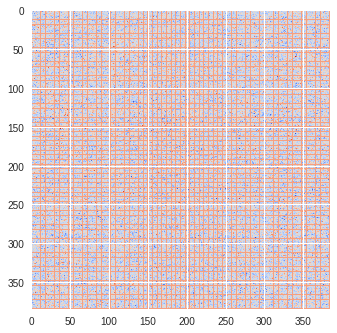

In [19]:
W = sess.run(mahi)
print(W.shape)
plt.imshow(montage(W / np.max(W)), cmap='coolwarm')

In [14]:
print(sess.run(accuracy,
                   feed_dict={
                       x: X_test.reshape(10000, 784),
                       y: y_test,
                       is_training: False
                   }))

0.987
